# Cloning quasars

Let's look at the redshift distributions of the quasars in the Sloan Digital Sky Survey.

The Sloan Digital Sky Survey or SDSS is a major multi-spectral imaging and spectroscopic redshift survey using a dedicated 2.5-m wide-angle optical telescope at Apache Point Observatory in New Mexico, United States. Operations started in 1998.

In phase 1, SDSS has released photometry data 357 million (!!!) unique sources and 1.6 million spectra. In phase 2, SDSS observed the same patch of the sky many times ("time domain astronomy", and now we're going to have LSST!)

![](https://classic.sdss.org/includes/sideimages/sdss_pie2.jpg)

Download the data on quasars from the SDSS: 

In [1]:
pip install astroML

Note: you may need to restart the kernel to use updated packages.


In [2]:
from astroML.datasets import fetch_dr7_quasar

# Fetch the quasar data
data = fetch_dr7_quasar()

# select the first 10000 points
data = data[:10000]

z = data['redshift']

- Upsample this distribution in two ways, using both rejection sampling and inverse transform.
- Check, at least visually, that the two cloned distribitions are indeed similar to the observed one (for a quantitative check, come back to this point in a few lectures)

(Hint: `scipy.stats` is your best friend)

- Think about the cosmology of quasars. How do you think they are distributed? Overplot the theorethical distribution to the measured SDSS data 

(Hint: `astropy.cosmology` is another close friend). The best-fit cosmological model from the Plack data is:

## Functions section:

- Rejection sampling

In [3]:
def find_bin_index(x_i, bins): 
    
    index = 0
        
    for j in range(0, len(bins) - 1):  # I need to check to which bin x_i belongs
            
        if x_i > bins[j] and x_i < bins[j + 1]: 
                
            index = j  # if I satisfy the "if" statement I save the bin index
    
    return index


def rejection_sampling(z, N):
    
    counts, bins = np.histogram(z, 50, density = True)
    x_i = uniform.rvs(0, np.max(z), N)  # I choose the proposal distribution to be the uniform one: 
    y_i = uniform.rvs(0, np.max(counts), N)  # I generate the y_i points uniformly 
    
    bin_x_i = []  # this vector will serve to store the indexes of bins to evaluate f(x_i) from histogram
    
    for i in x_i: 
    
        bin_x_i.append(find_bin_index(i, bins))
    
    return x_i[y_i < counts[bin_x_i]], y_i[y_i < counts[bin_x_i]]  # return only the values that fall below f(x_i)

- Inverse transfom sampling

In [4]:
def quantile_function(z, N, quant): 
    
    percentiles = [np.percentile(z, quant_i * 100) for quant_i in quant]
    
    return percentiles


def inverse_transf_sampling(z, N): 
    
    counts, bins = np.histogram(z, 50, density = True)
    
    us = uniform.rvs(0, 1, N)
    x_i = quantile_function(z, N, us)
    
    return x_i

## Solution section: 

I first start to plot the distribution of zs: 

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import uniform
import timeit

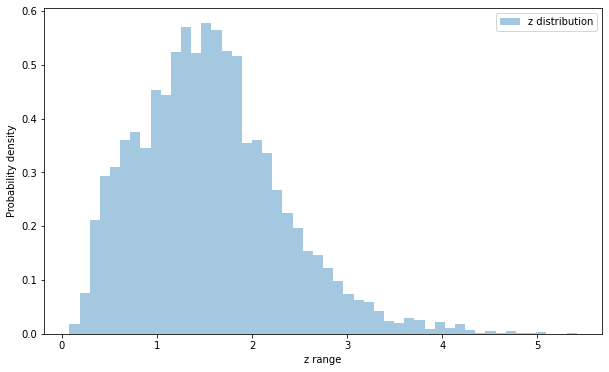

In [6]:
plt.figure(figsize=(10, 6))

plt.hist(z, 50, histtype='barstacked', density=True, alpha=0.4, edgecolor='none', label='z distribution');

plt.legend()
plt.ylabel('Probability density')
plt.xlabel('z range');

Now I try to sample the distribution to create some new points to work with (upsample my original dataset). 

### Rejection sampling: 

In [7]:
z_i, p_i = rejection_sampling(z, 10000)
time_rej_samp = timeit.timeit()

Plot the found points to see if they are from the above distribution: 

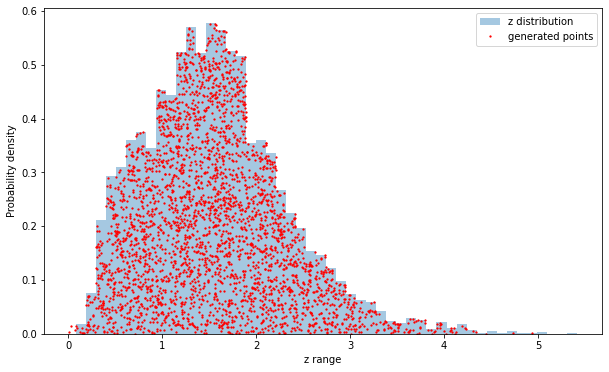

In [8]:
plt.figure(figsize=(10, 6))

plt.hist(z, 50, histtype='barstacked', density=True, alpha=0.4, edgecolor='none', label='z distribution');
plt.plot(z_i, p_i, '.', c = 'red', label='generated points', markersize=2.5)

plt.legend()
plt.ylabel('Probability density')
plt.xlabel('z range');

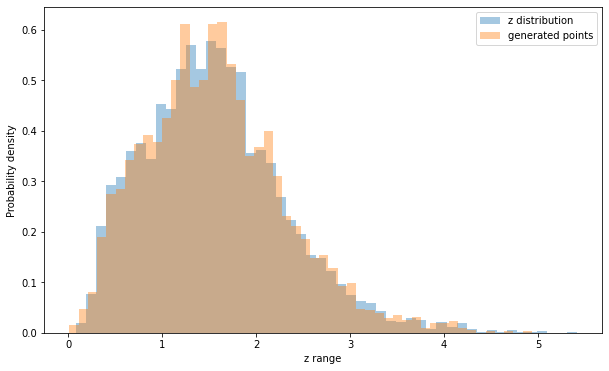

In [9]:
plt.figure(figsize=(10, 6))

plt.hist(z, 50, histtype='barstacked', density=True, alpha=0.4, edgecolor='none', label='z distribution');
plt.hist(z_i, label='generated points', alpha=0.4, density=True, bins = 50)

plt.legend()
plt.ylabel('Probability density')
plt.xlabel('z range');

### Inverse transform sampling:

From a uniform distribution $\in [0, 1]$ ($\mathrm{U(x)}$) we want to generate a random number $\textit{x}$, with cumulative function $\mathrm{F_{U}(x)}$. 

In [ ]:
z_cloned = inverse_transf_sampling(z, 10000)
time_inv_tras_samp = timeit.timeit()

In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(z, 50, histtype='barstacked', density=True, alpha=0.4, edgecolor='none', label='z distribution');
plt.hist(z_cloned, 50, histtype='barstacked', density=True, alpha=0.4, edgecolor='none', label='generated z distribution')

plt.legend()
plt.ylabel('Probability density')
plt.xlabel('z range');

I want to see the computational time used by the two methods (same N): 

In [ ]:
print("inverse:", time_inv_tras_samp, " rejection:", time_rej_samp)

In [ ]:
print("ratio: ", time_inv_tras_samp/time_rej_samp)

It's not that different but with the A/R method we throw away a considerable number of points while, with the other method we are always sure to extract a point that we can keep. 

### Physical discussion: 

I decided to use the points I obtained via $\textbf{inverse transform sampling}$, because they were more, and tried to do some statistics.

In [ ]:
cloned_z_tot = np.concatenate((z, z_cloned))

In [ ]:
len(cloned_z_tot)  # twice as long as the original one

Now I plot my "new" distribution: 

In [ ]:
plt.figure(figsize=(10, 6))

plt.hist(cloned_z_tot, 50, histtype='barstacked', alpha=0.4, edgecolor='none', label='cloned z distribution'); # non normalized distribution
plt.hist(z, 50, histtype='barstacked', alpha=0.4, edgecolor='none', label='z distribution');  # to compare with previous unnormalized one

plt.legend()
plt.ylabel('Probability density')
plt.xlabel('z range');

Cool. Now I try to evaluate the mean and understand the reasons fot it to be like that. 

In [ ]:
c_z_mean = np.mean(cloned_z_tot)
z_mean = np.mean(z)

In [ ]:
print("c_z_mean: ", c_z_mean, " z_mean: ", z_mean)

Why does it happen?

### Check with the theoretical distribution

In [ ]:
import astropy.cosmology
astropy.cosmology.Planck15?

In [ ]:
z_ls = np.linspace(0,5)

In [ ]:
pdf_ = 4.*np.pi*astropy.cosmology.Planck15.differential_comoving_volume(z_ls).value
norm_pdf = pdf_ / (4*np.trapz(pdf_, dx=0.01)) # arbitrarily normalized

In [ ]:
plt.plot(z_ls, norm_pdf)
plt.hist(z, 50, histtype='barstacked', density=True, alpha=0.4, edgecolor='none', label='z distribution');

It seems we are able to see this theoretical distribution only at small redshift, probably because higher sources are biased in the observation. 